## Examining Transit Data as a Multilayer Network
### Jeremy Kazimer
### Dane Taylor
### 6/12/2021

#### _Import Statements_

In [1]:
# Data structures
import numpy as np
import pandas as pds

# Visualization
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import colors as cm

# Utility functions
import sys
sys.path.append('utility/')
sys.path.append('data/')

from VNE_util import *

#### _Creating Networks_

We begin this experiment by generating geospatial transit networks according to the data posted [on this webpage](https://sites.google.com/site/danetaylorresearch/data?authuser=0).  Note that each node represents a different road intersection and that metro stations were projected to the nearest intersection.  Therefore, each edge represents a movable distance between two intersections, whether by road or metro.

In [2]:
folder = 'data/'

In [3]:
roads = pds.read_csv(folder + 'road_edge_list.csv', header = None) - 1
road_coordinates = pds.read_csv(folder + 'road_coordinates.csv', header = None)

metros = pds.read_csv(folder + 'reduced_metro_edge_list.csv', header = None) - 1

In [4]:
roads.head()

0  1
0   418  0
1   589  0
2  1726  0
3     6  1
4   163  1

In [5]:
road_coordinates.head()

0         1
0  51.503164 -0.127188
1  51.510034 -0.145588
2  51.510069 -0.145636
3  51.509121 -0.144423
4  51.509057 -0.144707

In the first dataframe, `roads`, each row has an x and y such that x is the index of one intersection and y is the index of the other intersection.  Hence, since it starts at `1`, there is a need to subtract one from both dataframes due to Python's indexing.  

We can now make the network by reading off the dataframes.

In [6]:
N_roads = max(roads[0].max(), roads[1].max()) + 1

A_roads = np.zeros((N_roads, N_roads))
A_metros = np.zeros((N_roads, N_roads))

In [7]:
# We'll use this later to distinguish the transportation type.
type_dict = {}

for road in roads.T:
    
    edge = roads.T[road]
    i, j = edge
    
    type_dict[(i, j)] = 'Road'
    type_dict[(j, i)] = 'Road'
    
    A_roads[i, j] = 1
    A_roads[j, i] = 1

for metro in metros.T:
    
    edge = metros.T[metro]
    i, j = edge
    
    type_dict[(i, j)] = 'Metro'
    type_dict[(j, i)] = 'Metro'
    
    A_metros[i, j] = 1
    A_metros[j, i] = 1 

In [8]:
road_nodes = 5.5
metro_nodes = 150.
road_color = 'black'
metro_color = 'black'

node_sizes = []
node_colors = []

nodes = (np.arange(0, N_roads)[A_metros.sum(axis = 1) > 0])

for i in range(N_roads):
    if i in nodes:
        node_sizes.append(metro_nodes)
        node_colors.append(metro_color)
    else:
        node_sizes.append(road_nodes)
        node_colors.append(road_color)

Now that we have it in adjacency form, we can simply create a NetworkX representation by plotting them separately.

In [9]:
G_roads = nx.from_numpy_array(A_roads)
pos_roads = nx.spring_layout(G_roads)

In [10]:
G_metros = nx.from_numpy_array(A_metros)

In [11]:
# We have to fix the 'pos' to make it realistic to the geospatial positioning.
for coordinate in road_coordinates.T:

    i, j = road_coordinates.T[coordinate]
    pos_roads[coordinate] = np.array((j, i))

#### _Making it a Multilayer_

Now, we can make a multilayer network by superimposing the networks onto each other by the equation

$$A = (1 - \chi)A_{road} + \chi A_{metro} $$

where $\chi$ is some scalar multiple $\chi \in \left[0, 1\right]$.  We can create a simple `lambda` function for this:

In [12]:
multilayer = lambda chi: (1 - chi)*A_roads + chi*A_metros

With this, we can look at different values of $\chi$ to understand the edge rankings.

#### _Edge Rankings_

We begin by creating a function that will store the edge rankings for different values of our time scale parameter $\beta$ in a dataframe, separated by the type of the edge:

In [13]:
def edge_rankings_df(A, type_dict, betas, epsilon = 1, print_stmt = True):
    
    concate_betas = np.array([])
    concate_types = np.array([])
    concate_ranks = np.array([])
    
    L = laplacian(A)
    eigs, vecs = np.linalg.eigh(L)
    
    edges = get_edges(A)
    types = []
    for edge in edges:
        tuple_edge = tuple(edge)
        types.append(type_dict[tuple_edge])
        
    types = np.array(types)
        
    for beta in betas:
        if print_stmt == True:
            print('beta: %s' % beta, '\r', end = '')
        _, _, ranks = transit_edge_rankings(A, eigs, vecs, beta, epsilon)
        
        concate_betas = np.append(concate_betas, np.full_like((np.zeros(ranks.shape[0])), beta))
        concate_types = np.append(concate_types, types)
        concate_ranks = np.append(concate_ranks, ranks)
        
    df = pds.DataFrame({'betas': concate_betas, 'rankings': concate_ranks, 'layers': concate_types})
    
    return df

In [14]:
# This can be configured to whatever you want.
betas = np.logspace(-1, 0.5, 21)

In [15]:
chis0 = [0.4, 0.60, 0.8]

A1 = multilayer(chis0[0])
A2 = multilayer(chis0[1])
A3 = multilayer(chis0[2])

Note that this should take a few minutes, so no worries if it seems to be taking a bit.

In [16]:
rankings1 = edge_rankings_df(A1, type_dict, betas)

29.31% done! 

14.40% done! 

79.40% done!

12.16% done!

In [17]:
rankings2 = edge_rankings_df(A2, type_dict, betas)

98.92% done!

22.83% done! 

0.03% done! 

In [18]:
rankings3 = edge_rankings_df(A3, type_dict, betas)

3.14% done! 

74.66% done!

54.48% done!

66.75% done! 

In [20]:
def nx_graph(G, pos, ranks, fig, ax, node_colors, node_sizes, edge_widths, cmap = plt.cm.winter, coloring = False):
    
    colors = ranks.astype(int)
    
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size = node_sizes, ax = ax, alpha = 1)
    edges = nx.draw_networkx_edges(G, pos, edge_color = colors, width = edge_widths,
                           edge_cmap=cmap, alpha = 0.9, ax = ax)
    
    if coloring == True:
        norm = cm.Normalize(vmin = 0, vmax = ranks.shape[0]) 
        sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm) 
        
        cbar_ax = fig.add_axes([0.5, 0.55, 0.01, 0.2])
        
        ax1 = fig.colorbar(sm, cax = cbar_ax)
        ax1.ax.set_ylabel('rank' + '\n', rotation = 270, fontsize = 14, labelpad = 20)
        
    else:
        ax1 = ax

    return ax, ax1

And looking at an example:

So, now what do we do with this data? Well, we can plot each individual component for different $\chi$ and then its average to understand its fluctuations without using standard deviation.  Note that we want to focus on the metro edges because the road edges are rather uneventful, but you can change that hardcoding in the function itself. We can create a function to do this:

In [21]:
def flatten_to_array(df, betas, A = A_metros):
    ranks = np.zeros((int(A.sum()/2), betas.shape[0]))
    
    for idx, beta in enumerate(betas):
        temp_df = df[df['layers'] == 'Metro']
        temp_df = temp_df[temp_df['betas'] == beta]
        
        ranks[:, idx] = np.array(temp_df['rankings'])
        
    return ranks

In [22]:
flatranks1 = flatten_to_array(rankings1, betas)
flatranks2 = flatten_to_array(rankings2, betas)
flatranks3 = flatten_to_array(rankings3, betas)

Now, we can look at the other relationship.  How do the rankings change for different $\chi$, fixing $\beta$ to be certain values?

In [23]:
betas1 = np.linspace(0.01, 3, 6)

In [24]:
chis = np.linspace(0.01, 0.99, 21)
avgs = np.zeros((betas1.shape[0], chis.shape[0]))

for idx, chi in enumerate(chis):
    print(idx, end = '\r')
    A_ = multilayer(chi)
    df = edge_rankings_df(A_, type_dict, betas1, 1, print_stmt = False)
    for jdx, beta in enumerate(betas1):
        df_ = df.copy()
        df_ = df_[df_['betas'] == beta]
        df_ = df_[df_['layers'] == 'Metro']

        avgs[jdx, idx] = df_['rankings'].mean()

Without sparing expense, we can plot these all together now:

In [25]:
G = nx.from_numpy_array(A2)

edge_widths = []

for idx, edge in enumerate(list(G.edges)):
    type_edge = type_dict[edge]
    if type_edge == 'Road':
        edge_widths.append(2)
    else:
        edge_widths.append(7)

In [28]:
save = False

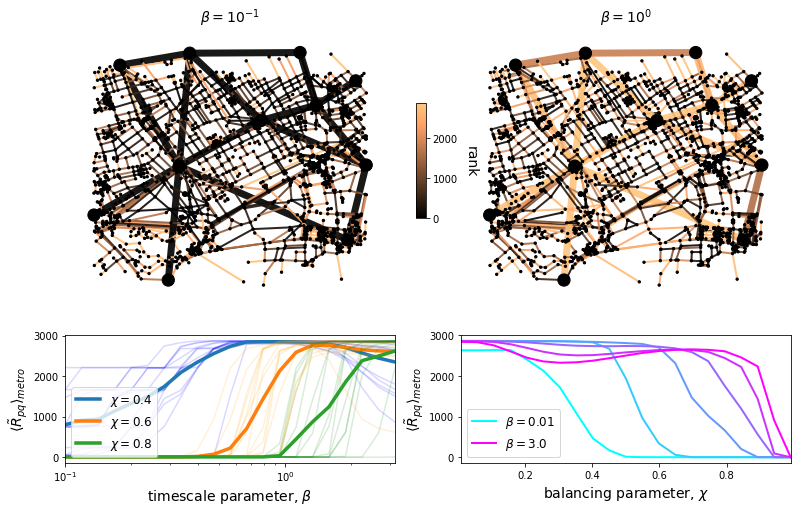

In [29]:
fig = plt.figure(figsize = (13, 8))
gs = fig.add_gridspec(3, 2)

ax0 = fig.add_subplot(gs[:2, 0])
ax = fig.add_subplot(gs[:2, 1])

chix = 0.75

small_ranks = np.array(rankings2[rankings2['betas'] == betas[0]]['rankings']).astype(int)
big_ranks = np.array(rankings2[rankings2['betas'] == betas[-7]]['rankings'])

cmap = plt.cm.copper
nx_graph(G, pos_roads, small_ranks, fig, ax0, node_colors, node_sizes, edge_widths, cmap = cmap, coloring = True)
nx_graph(G, pos_roads, big_ranks, fig, ax, node_colors, node_sizes, edge_widths, cmap = cmap)
    
ax0.set_title(r'$\beta = %s$' % r'10^{-1}', fontsize = 14)
ax.set_title(r'$\beta = %s$' % r'10^{0}', fontsize = 14)

ax.axis('off');
ax0.axis('off');

ax1, ax2 = fig.add_subplot(gs[2:, 0]), fig.add_subplot(gs[2:, 1])

ax1.semilogx(betas, flatranks1.T, c = 'blue', alpha = 0.15)
ax1.plot(betas, np.mean(flatranks1, axis = 0), lw = 3.5, label = r'$\chi = {}$'.format(chis0[0]))

ax1.plot(betas, flatranks2.T, c = 'orange', alpha = 0.15)
ax1.plot(betas, np.mean(flatranks2, axis = 0), lw = 3.5, label = r'$\chi = {}$'.format(chis0[1]))

ax1.plot(betas, flatranks3.T, c = 'green', alpha = 0.15)
ax1.plot(betas, np.mean(flatranks3, axis = 0), lw = 3.5, label = r'$\chi = {}$'.format(chis0[2]))

ax1.legend(loc = 'lower left', fontsize = 12, frameon = True)
ax1.set_ylabel(r'$\langle \tilde{R}_{pq}\rangle_{metro}$', fontsize = 14)
ax1.set_xlabel(r'timescale parameter, $\beta$', fontsize = 14)
ax1.set_xlim(betas[0], betas[-1])

cmap = plt.cm.cool
colors = cmap(np.linspace(0, 1, betas1.shape[0]))

for idx, avg in enumerate(avgs):
    if idx == 0 or idx == (len(avgs) - 1):
        ax2.plot(chis, avg, color = colors[idx], lw = 2, label = r'$\beta = %s$' % round(betas1[idx], 2))
    else:
        ax2.plot(chis, avg, color = colors[idx], lw = 2)

ax2.set_xlim(chis[0], chis[-1])
ax2.set_xlabel(r'balancing parameter, $\chi$', fontsize = 14)
ax2.set_ylabel('\n' + '\n' + '\n' + r'$\langle \tilde{R}_{pq}\rangle_{metro}$', fontsize = 14)
ax2.legend(loc = 'lower left', frameon = True, fontsize = 12)

if save == True:
    fig.savefig('figs/transport_test.pdf')

---